# Introduction

This is a companion notebook to the paper *"Tensor Renormalization Group Meets Computer Assistance"* (referred to as *"the paper"* below). It provides an implementation of the master map $\mathfrak{M}$ introduced in Section 2 of the paper. 

Note that in the code we drop all hats and checks, as all tensors are considered to be hat-tensors or check-tensors. The code is divided into sections corresponding to those in the paper. Each code block either defines a procedure from the corresponding section or generates a result presented therein.

The legs order for a 4-leg tensor $A$ is the same as in the paper:
         
          2
        1 A 3
          4

We equipped the paper with tags of the form $\langle \text{code ref.\ \#} \rangle$ placed at the right margin (where $\#$ denotes an ordinal number). We will refer to these tags by their ordinal numbers $\#$ as $\langle \# \rangle$. For example, the order of legs is also specified in $\langle 1 \rangle$. We also will refer to some sections of the paper just as Section #, where # is the number of the section in the paper.

The code relies on the following wonderful Julia packages:

- [`ArbNumerics.jl`](https://github.com/JeffreySarnoff/ArbNumerics.jl) for interval arithmetic  
- [`TensorOperations.jl`](https://github.com/Jutho/TensorOperations.jl) for tensor contractions  
- [`SpecialFunctions.jl`](https://github.com/JuliaMath/SpecialFunctions.jl) for Bessel functions  
- [`HCubature.jl`](https://github.com/JuliaMath/HCubature.jl) for evaluating exact free energy of 2d Ising model.
- [`Symbolics.jl`](https://github.com/JuliaSymbolics/Symbolics.jl) for obtaining symbolic expressions  
- [`TaylorSeries.jl`](https://github.com/JuliaDiff/TaylorSeries.jl) for determining the leading behavior of the map  
- [`CairoMakie.jl`](https://github.com/MakieOrg/Makie.jl) for visualization 
- [`Latexify.jl`](https://github.com/korsbo/Latexify.jl/tree/master) and [`LaTeXStrings.jl`](https://github.com/JuliaStrings/LaTeXStrings.jl) for nice LaTeX printing  
- [`ProgressMeter.jl`](https://github.com/timholy/ProgressMeter.jl) for showing the progress in long computations



In [1]:
using Pkg;
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Papers/HT`


# RG map and the master function
## Sectors

The code below defines constants representing the sectors introduced in Section 2.3.1, and defines a printing function called `print_tensor`.

In [2]:
# this defines constants o,x,d,u,r and the print_tensor function
using Latexify, LaTeXStrings

const o = 1;
const x = 2;
const d = 2;
const u = 3;
const r = 4;
const du = 4; # du and ud are indices to distinguish between d⊗u and u⊗d in λ₅ and ρ₅
const ud = 5; # see <13> 


const vsects = ["o", "x"]
const hsects = ["o", "d", "u", "r"]

"""
Input: 
- `A::Array`: some hat or check-tensor.
- `sector_labels::Vector...`: vectors containing the names of the sectors used in `A`. 
                             There should be a vector per leg of `A` and they should 
                             be given in the order of the legs of `A`.
- `output_latex_code::Bool`: if true, the function prints LaTeX code.

Output: 
- The function prints the tensor elements `A_{i₁, i₂, ...}` in the form "i₁, i₂, ... => A_{i₁ i₂ ...}", 
  one element per line or the LaTeX code corresponding to this output. 
- The function returns `nothing`.
"""
function print_tensor(A::Array, sector_labels::Vector...; output_latex_code::Bool=false)
    dims = size(A)
    leg_num = length(dims)

    indices = Iterators.product((1:d for d in dims)...)

    results = []

    for ind in indices
        val = A[ind...]
        if !(isequal(val, 0))
            if isempty(sector_labels)
                push!(results, (Tuple(ind) => val))
            else
                label = ntuple(i -> sector_labels[i][ind[i]], leg_num)
                push!(results, (label => val))
            end
        end
    end

    for entry in results
        if output_latex_code
            println(latexify(string(entry)))
        else
            display(latexify(string(entry)))
        end
    end

    return nothing
end;

## Gauge transformation 

The code below defines the `xo_gauge` function. It takes tensor $\widehat{A}$ and returns $\widehat{A}_1$ $\langle 10 \rangle$, $\widehat{\mathcal{N}}_1$ $\langle 11 \rangle$, and boolean `omega_flag`. During the procedure, we check that conditions listed in $\widehat{\Omega}_1$ $\langle 12 \rangle$ are satisfied and so our map is well defined. If this check passes `omega_flag==true`, otherwise `omega_flag==false` and the flow must be terminated. We called the gauge procedure here "`xo_`" to emphasize that it mixes the infinite dimensional sector $\mathbf{x}$ with finite dimensional sector $\mathbf{o}$.  

In [3]:
# this defines xo_gauge function
using TensorOperations
using LinearAlgebra

"""
Input: 
- `A::Array{T<:Number}`: the initial hat-tensor (\\hat{A} <8>). 
                         Must have dimensions `4, 2, 4, 2`, and A[o,o,o,o]=T(1).
- `omega_checks::Bool`: if true, the code checks whether the conditions listed in \\hat{Ω}₁ in the paper are satisfied (see <12>).

Output:
- `A₁::Array{T}`: the hat-tensor \\hat{A}_1 <10>.
- `N₁::T`: the normalization constant \\mathcal{N}_1 <11>.
- `omega_flag::Bool`: a flag indicating whether the conditions listed in \\hat{Ω}₁ <12> are satisfied.
"""
function xo_gauge(A::Array{T}; omega_checks::Bool=true) where {T<:Number}

    # computing \hat{β}ₕ, \hat{β}ᵥ and checking \hat{Ω}₁ conditions

    βₕ = dot(A[o, o, d:r, o], A[d:r, o, o, o]) # in paper these equations <9> are written with \hat{b} 
    βᵥ = A[o, o, o, x] * A[o, x, o, o]         # instead of \hat{A}, but this is the same.


    omega_flag::Bool = true # we write omega_flag explicitly for readability

    if omega_checks && βᵥ > 1
        @error "xo_gauge: βᵥ > 1"
        omega_flag = false
        return A, T(1), omega_flag
    end

    if omega_checks && βₕ > 1
        @error "xo_gauge: βₕ > 1"
        omega_flag = false
        return A, T(1), omega_flag
    end

    # defining hat{h}_i's, \hat{v}_i's, and the set of cancelled diagrams
    # see <4> and <5> and the corresponding discussion of the hat
    # tensors
    # legs order:
    #                1
    #     1 h 2      v           
    #                2
    #
    v = [zeros(T, 2, 2) for i = 1:5]
    v[1][o, o] = T(1)
    v[2][x, x] = T(1)
    v[3][o, x] = A[o, o, o, x]
    v[4][x, o] = A[o, x, o, o]
    v[5][o, o] = A[o, o, o, x] * A[o, x, o, o] / (1 + sqrt(1 - βᵥ))
    v[5][x, x] = A[o, x, o, o] * A[o, o, o, x] / (1 + sqrt(1 - βᵥ))

    h = [zeros(T, 4, 4) for i = 1:5]
    h[1][o, o] = T(1)
    h[2][d:r, d:r] .= diagm([T(1) for i = d:r])
    h[3][o, d:r] .= A[o, o, d:r, o]
    h[4][d:r, o] .= A[d:r, o, o, o]
    h[5][o, o] = dot(A[o, o, d:r, o], A[d:r, o, o, o]) / (1 + sqrt(1 - βₕ))
    h[5][d:r, d:r] .= 1 / (1 + sqrt(1 - βₕ)) * A[d:r, o, o, o] * A[o, o, d:r, o]'


    C = Set([[2, 1, 1, 1], [4, 1, 1, 1], [1, 2, 1, 1], [1, 4, 1, 1],
        [1, 1, 2, 1], [1, 1, 3, 1], [1, 1, 1, 2], [1, 1, 1, 3]])
    # this is the set of cancelled diagrams, see <7>

    # computing the \hat{A}_g by summing up diagrams <6>
    D = zero(A)
    A_g = zero(A)
    for i = 1:5, j = 1:5, k = 1:5, l = 1:5
        if !([i, j, k, l] in C)
            @tensor D[1, 2, 3, 4] = A[-1, -2, -3, -4] * h[i][1, -1] *
                                    v[j][2, -2] * h[k][-3, 3] * v[l][-4, 4]
            A_g += D
        end
    end

    # the normalization constant <11>
    N₁ = A_g[o, o, o, o]

    # the last omega check <12>
    if omega_checks && (2 - N₁ <= 0)
        @error "xo_gauge: 2-N₁ ≤ 0"
        omega_flag = false
        return A, N₁, omega_flag
    end

    # normalization, see below <11>
    A₁ = A_g / (T(2) - N₁)
    A₁[o, o, o, o] = T(1)

    return A₁, N₁, omega_flag
end;

## Disentangling and Splitting

The code below defines the `define_LR` function. It takes tensor $\widehat{A}_1$ $\langle 10 \rangle$ and returns $\widehat{L}^\varkappa$, $\widehat{R}^{\varkappa}$ $\langle 20 \rangle$, and `omega_flag`. During the procedure, we check that the condition from $\widehat{\Omega}_{LR}$ $\langle 24 \rangle$ is satisfied and so our map is well defined. If this check passes `omega_flag==true`, otherwise `omega_flag==false` and the flow must be terminated.

In [4]:
# this defines define_LR

"""
Input:
- `A::Array{T}`: any hat or check tensor.
- `index_sets::Vector`: a list `[index_sets[1], index_sets[2], …, index_sets[n]]`, where `n` is the number of legs of `A`. 
                        An empty entry `index_sets[leg]=[]` is shorthand for `axes(A, leg)`, i.e. “all indices” on that leg.

Output: 
- `A_restricted::Array{T}`: a copy of `A` with leg `leg` restricted to `index_sets[leg]`. 
                            That is: `A_restricted[j₁, ..., jₙ]=A[j₁,...,jₙ]` if `j₁ ∈ index_sets[1], ..., jₙ ∈ index_sets[n]` 
                            and `A_restricted[j₁, ..., jₙ]=0` otherwise.
"""
function restrict(A::Array{T}, index_sets::Vector) where {T<:Number}
    num_of_legs = length(index_sets)

    # True if the index on the given leg is in the corresponding index set,
    # or if the index set is empty (meaning index set=“all indices”).
    one_leg_in_index_set(index, leg) =
        (index in index_sets[leg]) || (isempty(index_sets[leg]))

    # True only when the indices on *all* legs lie in their respective index lists.
    all_legs_in_index_sets(indices) =
        prod([one_leg_in_index_set(indices[leg], leg) for leg = 1:num_of_legs])


    # Boolean array the same size as A:
    # false → indices inside the specified index sets (remain unchanged),
    # true → at least one index outside (to be zeroed).
    mask = [!all_legs_in_index_sets(indices) for indices in CartesianIndices(size(A))]

    A_restricted = copy(A)

    A_restricted[mask] .= T(0) # this takes all entries of A for which mask has value true and sets them to zero.

    return A_restricted
end

"""
This function is a complement of `restrict`: set_to_zero(A, index_sets)=A-restrict(A,index_sets).

Input:
- `A::Array{T}`: any hat or check tensor.
- `index_sets::Vector`: a list `[index_sets[1], index_sets[2], …, index_sets[n]]`, where `n` is the number of legs of `A`. 
                        An empty entry `index_sets[leg]=[]` is shorthand for `axes(A, leg)`, i.e “all indices” on that leg.

Output:
- `A_zeroed::Array{T}`: a copy of `A` in which every element whose indices **all lie in the specified sectors** has been set to zero, 
                        while elements with at least one index **outside** the sectors are left unchanged. 
                        That is: `A_zeroed[j₁, ..., jₙ]=0` if `j₁ ∈ index_sets[1], ..., jₙ ∈ index_sets[n]` 
                        and `A_zeroed[j₁, ..., jₙ]=A[j₁,...,jₙ]` otherwise. 
"""
function set_to_zero(A::Array{T}, index_sets::Vector) where {T<:Number}
    num_of_legs = length(index_sets)

    # True if the index on the given leg is in the corresponding index set,
    # or if the index set is empty (meaning index set=“all indices”).
    one_leg_in_index_set(index, leg) =
        (index in index_sets[leg]) || (isempty(index_sets[leg]))

    # True only when the indices on *all* legs lie in their respective index lists.
    all_legs_in_index_sets(indices) =
        prod([one_leg_in_index_set(indices[leg], leg) for leg = 1:num_of_legs])

    # Boolean array the same size as A:
    # true → indices inside the specified sets (to be zeroed),
    # false → at least one index outside (remain unchanged).
    mask = [all_legs_in_index_sets(indices) for indices in CartesianIndices(size(A))]

    A_zeroed = copy(A)
    A_zeroed[mask] .= T(0) # This takes all entries of A for which mask has value true and sets them to zero.

    return A_zeroed
end

"""
Input: 
- `L::Array{T}`: one of the 6-leg \\hat{L}^{(j)}_q (j=0,1,2; q=z,xx,xo,ox,oo) tensors <15>, <18>.

Output:
- A tensor with three legs, corresponding to the bottom, left, and top legs of `L`,
  containing the sum of squares of the elements of `L` over all other legs. 
  This sum gives the contribution of a given \\hat{L}^{(j)}_q to the sum in <23>.
"""
function collapse_quad_L(L::Array{T}) where {T<:Number}
    # legs ordering:
    #
    #           2         
    #           |
    #           |--3      
    #        1--L--4    
    #           |--5
    #           |      
    #           6          
    sum(L[:, :, i, j, k, :] .^ 2 for i = o:ud, j = o:r, k = o:ud)
end

"""
Input: 
- `R::Array{T}`: one of the 6-leg \\hat{R}^{(j)}_q (j=0,1,2; q=z,xx,xo,ox,oo) tensors <15>, <18>.

Output:
- A tensor with three legs, corresponding to the bottom, right, and top legs of `R`,
  containing the sum of squares of the elements of `R` over all other legs. 
  This sum gives the contribution of a given \\hat{R}^{(j)}_q to the right version of the sum in <23>.
"""
function collapse_quad_R(R::Array{T}) where {T<:Number}
    # legs ordering:
    #
    #            4         
    #            |
    #         1--|      
    #         2--R--5    
    #         3--|
    #            |      
    #            6     
    sum(R[i, j, k, :, :, :] .^ 2 for i = o:ud, j = o:r, k = o:ud) 
end

"""
Input: 
- `A::Array{T<:Number}`: the \\hat{A}_1 tensor <10>. Must have dimensions `4, 2, 4, 2` and A[o,o,o,o]=T(1).
- `wx, wo`: reweighing parameters of the 2x1 map
- `do_tests::Bool`: if true, function will run a series of tests to check that splitting was done correctly 
- `omega_checks::Bool`: if true, the code checks whether the conditions listed in \\hat{Ω}_{LR} <24> are satisfied.

Output:
- `L::Array{T<:Number}, R::Array{T<:Number}`: hat-tensors \\hat{L}^\\kappa and \\hat{R}^{\\kappa} <20>.
- `omega_flag::Bool`: a flag indicating whether the condition from \\hat{Ω}_{LR} in satisfied.
"""
function define_LR(A::Array{T}, wx, wo; do_tests::Bool=false, omega_checks::Bool=true) where {T}

    # defining \hat{α} <21> and checking the corresponding \hat{Ω}_{LR} condition <24>
    α = A[o, o, d, x] * A[d, o, o, x] * A[u, x, o, o] * A[o, x, u, o]

    L = zeros(T, 4, 2, 2, 2) # These L and R correspond to \hat{L}^\kappa and \hat{R}^\kappa <20>.
    R = zeros(T, 2, 2, 4, 2)

    omega_flag = true

    if omega_checks && α > 1
        @error "define_LR: α > 1"
        omega_flag = false
        return L, R, omega_flag
    end

    # defining \hat{λ}, \hat{ρ} (see <13> and the hat-tensors discussion in Section 2.7.6)
    # legs order:
    #
    #   1          1 
    #   λ 3      3 ρ
    #   2          2
    # 

    root_factor = sqrt(1 / (1 + sqrt(1 - α)))
    λ = [zeros(T, 2, 2, 5) for _ = 1:5]
    ρ = [zeros(T, 2, 2, 5) for _ = 1:5]


    λ[1][o, o, o] = T(1)
    λ[2][x, x, o] = T(1)
    λ[3][o, x, d] = A[o, o, d, x]
    λ[4][x, o, u] = A[o, x, u, o]
    λ[5][o, o, du] = root_factor * A[o, o, d, x] * A[o, x, u, o]
    λ[5][x, x, ud] = root_factor * A[o, x, u, o] * A[o, o, d, x]

    ρ[1][o, o, o] = T(1)
    ρ[2][x, x, o] = T(1)
    ρ[3][o, x, d] = A[d, o, o, x]
    ρ[4][x, o, u] = A[u, x, o, o]
    ρ[5][o, o, du] = root_factor * A[d, o, o, x] * A[u, x, o, o]
    ρ[5][x, x, ud] = root_factor * A[u, x, o, o] * A[d, o, o, x]

    # defining contraction of A with two λ's or ρ's and with one leg restricted to 
    # collection of sectors s  (a collection s may include single sector or several sectors) 
    # as in <16> in the paper but without restricting the "outer" leg to o 
    # legs order (label s shows which leg is restricted):
    #          2          4
    #          λ 3      1 ρ
    #        1 A 4s    s2 A 5
    #          λ 5      3 ρ
    #          6          6
    #
    #

    function Aλλ(i, s, j)
        A_restricted = restrict(A, [[], [], s, []]) # empty sets mean that the corresponding legs are not restricted
        @tensor Aλλ_isj[1, 2, 3, 4, 5, 6] := A_restricted[1, -1, 4, -2] * λ[i][2, -1, 3] * λ[j][-2, 6, 5]
        return Aλλ_isj
    end

    function Aρρ(i, s, j)
        A_restricted = restrict(A, [s, [], [], []])
        @tensor Aρρ_isj[1, 2, 3, 4, 5, 6] := A_restricted[2, -1, 5, -2] * ρ[i][4, -1, 1] * ρ[j][-2, 6, 3]
        return Aρρ_isj
    end

    # defining the "full" contractions of A with λ λ and with ρ ρ
    # These correspond to hat tensors of left and right halves of 
    # r.h.s of <14>.

    Aλλ_full = sum([Aλλ(i, [], j) for i = 1:5, j = 1:5])
    Aρρ_full = sum([Aρρ(i, [], j) for i = 1:5, j = 1:5])

    # defining Lz0, Rz0 by restricting the full Aλλ_full and Aρρ_full contractions to the zero channel
    # Zero here correspond to the superscript (0) in the paper, i.e. 
    # Lz0 and Rz0 are \hat{L}_z^{(0)} and \hat{R}_z^{(0)} defined in <15> in the paper. 
    # We don't use the auxiliary space explicitly in the code, so we do not
    # define \hat{L}_z and \hat{R}_z. 

    # Note that our goal here is to compute <22> and <23> (and their R analogues). 
    # The r.h.s. of <22> can be expressed easily in terms of \hat{L}_z^{(0)}.
    # The r.h.s. of <23> can be expressed in terms of \hat{L}_{q}^{(0)} (q=xx,ox,xo) and
    # \hat{L}_{oo}^{(1)}, \hat{L}_{oo}^{(2)} (see also below <23>). 
    # By doing so we completely eliminate the auxiliary space from the computation.
    # Particular expressions go right after the definitions of all necessary tensors and 
    # the block of code that tests if channels are reproduced correctly.

    Lz0 = restrict(Aλλ_full, [[], [], [o], [o], [o], []])
    Rz0 = restrict(Aρρ_full, [[o], [o], [o], [], [], []])

    # removing the zero channel from Aλλ, Aρρ for further use

    Aλλ_non_zero_channel = set_to_zero(Aλλ_full, [[], [], [o], [o], [o], []])
    Aρρ_non_zero_channel = set_to_zero(Aρρ_full, [[o], [o], [o], [], [], []])

    # Label "_non_zero_channel" corresponds to the red line with "\neq 0" sign 
    # cutting through the bonds in the paper.

    # defining Lxx0, Lxo0, Lox0 and their R versions <15>
    # Zero here corresponds to (0) superscript in the paper.

    Lxx0 = restrict(Aλλ_non_zero_channel, [d:r, [], [], [], [], []]) # Recall that x on hor. space is exactly d:r.
    Rxx0 = restrict(Aρρ_non_zero_channel, [[], [], [], [], d:r, []])

    Lxo0 = restrict(Aλλ_non_zero_channel, [d:r, [], [], [], [], []]) * wx
    Rxo0 = restrict(Aρρ_non_zero_channel, [[], [], [], [], [o], []]) / wx

    Lox0 = restrict(Aλλ_non_zero_channel, [[o], [], [], [], [], []]) / wx
    Rox0 = restrict(Aρρ_non_zero_channel, [[], [], [], [], d:r, []]) * wx

    # working out oo channel 
    # We do not define \hat{L}_oo itself instead working with \hat{L}_oo^{(1)}, \hat{L}_oo^{(2)} and \hat{L}_oo^{(1)}*Py (same for R) <18>, <19>.

    # building the cancellation set \mathcal{E} <17> and its complement 
    E = [(2, [u], 1), (1, [d], 2), (4, [o], 1), (1, [o], 3)]

    # start of E_complement definition
    E_complement = [(2, [o, d, r], 1), (1, [o, u, r], 2), (4, [d, u, r], 1), (1, [d, u, r], 3)]
    for i = 1:5, j = 1:5
        already_added=((i == 2 && j == 1) || (i == 1 && j == 2) || (i == 4 && j == 1) || (i == 1 && j == 3))
        if !already_added
            push!(E_complement, (i, [], j))
        end
    end
    # end of E_complement definition

    # Below 1 and 2 correspond to superscripts (1) and (2) in the paper.
    # The "Py" label corresponds to multiplication by P_Y projector as in <19>. 
    # Note that we absorbed the w_0 coefficients into the tensors 
    # here. These coefficients were explicit factors in <19>.   
    Loo1 = restrict(set_to_zero(sum(Aλλ(dgrm...) for dgrm in E_complement), [[], [], [o], [o], [o], []]), [[o], [], [], [], [], []])
    Loo2 = restrict(sum(Aλλ(dgrm...) for dgrm in E), [[o], [], [], [], [], []]) / wo # we don't need to apply "set_to_zero" here to the right three legs as  
                                                                                     # diagrams from E are already zero when those legs are ooo. 
    Loo1Py = (restrict(Loo1, [[], [], [o], d:u, [o], []]) + restrict(Loo1, [[], [], [u], [o], [o], []]) + restrict(Loo1, [[], [], [o], [o], [d], []])) * wo

    Roo1 = restrict(set_to_zero(sum(Aρρ(dgrm...) for dgrm in E_complement), [[o], [o], [o], [], [], []]), [[], [], [], [], [o], []])
    Roo2 = restrict(sum(Aρρ(dgrm...) for dgrm in E), [[], [], [], [], [o], []]) / wo
    PyRoo1 = (restrict(Roo1, [[o], d:u, [o], [], [], []]) + restrict(Roo1, [[u], [o], [o], [], [], []]) + restrict(Roo1, [[o], [o], [d], [], [], []])) * wo


    if do_tests # tests to ensure that all sectors are correctly reconstructed.
        @tensor rhs[1, 2, 3, 4, 5, 6] := Aλλ_non_zero_channel[1, 2, -1, -2, -3, 5] * Aρρ_non_zero_channel[-1, -2, -3, 3, 4, 6]
        @tensor lhs[1, 2, 3, 4, 5, 6] := Lxx0[1, 2, -1, -2, -3, 5] * Rxx0[-1, -2, -3, 3, 4, 6]
        println("xx test: ", norm(lhs - restrict(rhs, [d:r, [], [], d:r, [], []])) / norm(rhs))

        @tensor lhs[1, 2, 3, 4, 5, 6] = Lxo0[1, 2, -1, -2, -3, 5] * Rxo0[-1, -2, -3, 3, 4, 6]
        println("xo test: ", norm(lhs - restrict(rhs, [d:r, [], [], [o], [], []])) / norm(rhs))

        @tensor lhs[1, 2, 3, 4, 5, 6] = Lox0[1, 2, -1, -2, -3, 5] * Rox0[-1, -2, -3, 3, 4, 6]
        println("ox test: ", norm(lhs - restrict(rhs, [[o], [], [], d:r, [], []])) / norm(rhs))

        @tensor lhs[1, 2, 3, 4, 5, 6] = Loo2[1, 2, -1, -2, -3, 5] * PyRoo1[-1, -2, -3, 3, 4, 6]
        @tensor rhs[1, 2, 3, 4, 5, 6] = Loo2[1, 2, -1, -2, -3, 5] * Roo1[-1, -2, -3, 3, 4, 6]
        println("Loo2 ---PyRoo1 vs ---Roo1 test: ", norm(lhs - rhs * wo) / norm(rhs))

        @tensor lhs[1, 2, 3, 4, 5, 6] = Loo1Py[1, 2, -1, -2, -3, 5] * Roo2[-1, -2, -3, 3, 4, 6]
        @tensor rhs[1, 2, 3, 4, 5, 6] = Loo1[1, 2, -1, -2, -3, 5] * Roo2[-1, -2, -3, 3, 4, 6]
        println("Loo1Py--- vs Loo1--- Roo2 test: ", norm(lhs - rhs * wo) / norm(rhs))


        @tensor lhs1[1, 2, 3, 4, 5, 6] := Loo1[1, 2, -1, -2, -3, 5] * Roo1[-1, -2, -3, 3, 4, 6]
        @tensor lhs2[1, 2, 3, 4, 5, 6] := Loo1Py[1, 2, -1, -2, -3, 5] * Roo2[-1, -2, -3, 3, 4, 6]
        @tensor lhs3[1, 2, 3, 4, 5, 6] := Loo2[1, 2, -1, -2, -3, 5] * PyRoo1[-1, -2, -3, 3, 4, 6]
        @tensor lhs4[1, 2, 3, 4, 5, 6] := Loo2[1, 2, -1, -2, -3, 5] * Roo2[-1, -2, -3, 3, 4, 6]
        @tensor rhs[1, 2, 3, 4, 5, 6] := Aλλ_non_zero_channel[1, 2, -1, -2, -3, 5] * Aρρ_non_zero_channel[-1, -2, -3, 3, 4, 6]

        println("oo test: ", norm(lhs1 + lhs2 + lhs3 + lhs4 * wo^2 - restrict(rhs, [[o], [], [], [o], [], []])) / norm(rhs))
    end

    Lxx0_collapsed = collapse_quad_L(Lxx0) # Here, the collapse function sums the squares of 
    Lox0_collapsed = collapse_quad_L(Lox0) # tensor elements of \hat{L}_q^{(0)} over the three 
    Lxo0_collapsed = collapse_quad_L(Lxo0) # right legs. The "_collapsed" tensors contain contributions  
    # to <23> from the corresponding \hat{L}^{(0)}_q.

    Loo1_collapsed = collapse_quad_L(Loo1) # these three terms are contributions to <23> from 
    Loo1Py_collapsed = collapse_quad_L(Loo1Py) # \hat{L}^{(1)}_oo, \hat{L}^{(2)}_oo, and \hat{L}^{(1)}_oo P_Y <19>. 
    Loo2_collapsed = collapse_quad_L(Loo2) 

    Rxx0_collapsed = collapse_quad_R(Rxx0) # similar expressions for R
    Rox0_collapsed = collapse_quad_R(Rox0)
    Rxo0_collapsed = collapse_quad_R(Rxo0)

    Roo1_collapsed = collapse_quad_R(Roo1)
    PyRoo1_collapsed = collapse_quad_R(PyRoo1)
    Roo2_collapsed = collapse_quad_R(Roo2)

    L[:, :, o, :] .= Lz0[:, :, o, o, o, :] # this is <22>
    L[:, :, x, :] .= sqrt.(Lxx0_collapsed + Lox0_collapsed + Lxo0_collapsed + Loo1_collapsed + Loo1Py_collapsed + Loo2_collapsed) # this is <23>
    # this expression looks a bit differently from <23>, but it is, in fact, the same. Each of the terms here
    # corresponds to some particular chunk in the sum on the r.h.s. of <23>. These chunks do not overlap. 
    # The last three terms are all contributions from \hat{L}^\kappa_{oo}. 

    R[o, :, :, :] .= Rz0[o, o, o, :, :, :] # analogous expressions for R
    R[x, :, :, :] .= sqrt.(Rxx0_collapsed + Rox0_collapsed + Rxo0_collapsed + Roo1_collapsed + PyRoo1_collapsed + Roo2_collapsed)

    return L, R, omega_flag
end;

## Reconnection and rotation

The code below defines functions `reconnect_and_rotate` and `master_function` (with its alias `𝔐`). 

The `reconnect_and_rotate` function takes $\widehat{L}^\varkappa$ and $\widehat{R}^\varkappa$ tensors and returns $\widehat{A}'$ $\langle 26 \rangle$, $\widehat{\mathcal{N}}_2$ $\langle 25 \rangle$, and boolean `omega_flag`. During the procedure, we check that the condition from $\widehat{\Omega}_2$ $\langle 29 \rangle$ is satisfied and so our map is well defined. If this check passes `omega_flag=true`, otherwise `omega_flag=false` and the flow must be terminated. 

The `master_function` function combines `xo_gauge`, `define_LR`, and `reconnect_and_rotate` into one function. It takes $\widehat{A}$ and returns $\widehat{A}'$, $\widehat{\mathcal{N}}$ $\langle 31 \rangle$, and boolean `omega_flag` that is true iff omega flags of all substeps are `true`. In other words, `omega_flag==true` iff all conditions from $\widehat{\Omega}$ $\langle 30 \rangle$ are satisfied. If `omega_flag==false`, the flow must be terminated.

In [5]:
# this defines reconnect_and_rotate and master_function functions 

"""
Input: 
- `L::Array{T<:Number}, R::Array{T<:Number}`: \\hat{L}^\\kappa and \\hat{R}^{\\kappa} from <22>,<23>.
- `omega_checks::Bool`: if true, the code checks whether the condition from \\hat{Ω}₂ <29> is satisfied.

Output:
- `Ap::Array{T}`: \\hat{A}' <26>.
- `N₂::T`: the normalization constant \\mathcal{N}_2 <25>.
- `omega_flag::Bool`: a flag indicating whether the condition from \\hat{Ω}₂ <29> is satisfied.
"""
function reconnect_and_rotate(L::Array{T}, R::Array{T}; omega_checks::Bool=true) where {T}
    omega_flag = true
    # defining J <27>
    # legs order:
    #
    #            3
    #            J
    #           1 2
    #

    J = zeros(T, 2, 2, 4)
    J[o, o, o] = T(1)
    J[x, o, d] = T(1)
    J[o, x, u] = T(1)
    J[x, x, r] = T(1)

    # the following line performs both contraction and rotation 
    # so, Ar is a rotated version of \hat{A}_r <25>.
    @tensor Ar[1, 2, 3, 4] := R[4, -1, -2, -4] * L[-2, -3, 2, -5] * J[-1, -3, 1] * J[-4, -5, 3]

    N₂ = Ar[o, o, o, o] # <25>

    if omega_checks && 2 - N₂ ≤ 0
        @error "reconnect_and_rotate: 2 - N₂ ≤ 0"
        omega_flag = false
        return Ar, omega_flag
    end

    Ap = Ar / (T(2) - N₂)
    Ap[o, o, o, o] = T(1)

    return Ap, N₂, omega_flag
end

"""
Input: 
- `A::Array{T<:Number}`: the initial hat-tensor (\\hat{A} <8>). Must have dimensions `4, 2, 4, 2` and A[o,o,o,o]=T(1).
- `wx, wo`: reweighing parameters of the 2x1 map
- `omega_checks::Bool`: if true, the code checks whether the conditions listed in \\hat{Ω} <30> are satisfied.

Output:
- `Ap::Array{T}`: \\hat{A}' <26>.
- `N::T`: the upper bound on \\mathcal{N} <25>.
- `omega_flag::Bool`: a flag indicating whether the conditions listed in \\hat{Ω} <30> are satisfied.
"""
function master_function(A::Array; wx=2.2, wo=2.0, omega_checks=true)
    A₁, N₁, omega_gauge = xo_gauge(A; omega_checks=omega_checks)
    L, R, omega_LR = define_LR(A₁, wx, wo; omega_checks=omega_checks)
    Ap, N₂, omega_reconnect = reconnect_and_rotate(L, R; omega_checks=omega_checks)
    omega_flag = omega_gauge && omega_LR && omega_reconnect
    N = N₁^2 * N₂
    return Ap, N, omega_flag
end;
const 𝔐 = master_function;


## Constraints on $w_{\mathbf{x}}$ and $w_{\mathbf{o}}$ from linear stability

Here we provide code generating $\langle 33 \rangle$.

The first three cells are technical definitions that allow the `Symbolics.jl`, `TaylorSeries.jl`, and `TensorOperations.jl` packages work together. The fourth cell defines the symbolic tensor $\hat{A}$ and evaluates $\langle 32 \rangle$.

In [6]:
# this makes TaylorSeries package compatible with Symbolics.
using TaylorSeries;
using Symbolics;
# this block of code is taken from here: https://github.com/JuliaDiff/TaylorSeries.jl/blob/lb/Symbolics/src/symbolics.jl

import Base: +, -, *, /

# Promotion rules
promote_rule(::Type{Taylor1{T}}, ::Type{Num}) where {T<:Number} =
    Taylor1{promote_type(T, Num)}

function promote(a::Taylor1{T}, b::S) where {T<:Real,S<:Num}
    R = promote_type(T, S)
    return Taylor1(convert(Array{R}, a.coeffs)), Taylor1(convert(R, b), a.order)
end
promote(b::S, a::Taylor1{T}) where {T<:Real,S<:Num} = reverse(promote(a, b))

promote(a::Taylor1{Num}, b::Num) = a, Taylor1(b, a.order)
promote(b::Num, a::Taylor1{Num}) = reverse(promote(a, b))



# Arithmetics
for f in (:+, :-)
    @eval begin
        ($f)(a::Taylor1{T}, b::Num) where {T<:Number} = ($f)(promote(a, b)...)
        ($f)(b::Num, a::Taylor1{T}) where {T<:Number} = ($f)(promote(b, a)...)
    end
end

function *(a::Num, b::Taylor1{T}) where {T<:Number}
    @inbounds aux = a * b.coeffs[1]
    v = Array{typeof(aux)}(undef, length(b.coeffs))
    @__dot__ v = a * b.coeffs
    return Taylor1(v, b.order)
end
*(b::Taylor1{T}, a::Num) where {T<:Number} = a * b

function *(a::T, b::Taylor1{T}) where {T<:Num}
    @inbounds aux = a * b.coeffs[1]
    v = Array{typeof(aux)}(undef, length(b.coeffs))
    @__dot__ v = a * b.coeffs
    return Taylor1(v, b.order)
end
*(b::Taylor1{T}, a::T) where {T<:Num} = a * b


function /(a::Taylor1{T}, b::Num) where {Num <: T <: Union{Real,Complex}}
    v = a.coeffs ./ b
    return Taylor1(v, a.order)
end

Symbolics.substitute(a::Taylor1{Num}, d::Pair) = Taylor1(substitute.(a.coeffs, (d,)));

In [7]:
# these functions needed for @tensor to work properly with Symbolics. 
import Base: *, convert
function *(::Num, v::TensorOperations.VectorInterface.Zero)
    return Num(0)
end
function *(a::Num, v::TensorOperations.VectorInterface.One)
    return a
end
function convert(::Type{Num}, ::TensorOperations.VectorInterface.Zero)
    Num(0)
end
function convert(::Type{Num}, ::TensorOperations.VectorInterface.One)
    Num(1)
end;

In [8]:
# this allows to define symbols with non numerical indices
function form_index(idx, labels...)
    res = "_{"
    for (i, lbls) = zip(idx, labels)
        res *= lbls[i]
    end
    res *= "}"
    return res
end
function tensor_element(name, idx, labels...; T=Real)
    indexed_name = Symbol(name, form_index(idx, labels...))
    v = Symbolics.Sym{T}(indexed_name)
    Num(Symbolics.setmetadata(v, Symbolics.VariableSource, (:variables, indexed_name)))
end;

In [9]:
# this provides <33>.
t = Taylor1(Num, 2) # we need to use second order polynomials as there are square roots in the expression.
A = t * [tensor_element("b", (i, j, k, l), hsects, vsects, hsects, vsects) for i = 1:4, j = 1:2, k = 1:4, l = 1:2]
A[1, 1, 1, 1] = typeof(t)(1);

wx = tensor_element("w", (2,), vsects)
wo = tensor_element("w", (1,), vsects)

Ap, _ = 𝔐(A; wx=wx, wo=wo, omega_checks=false) # we suppress the omega_checks for symbolic mode 
print_tensor((Ap .|> x -> x.order > 0 ? getcoeff(x, 1) : 0), hsects, vsects, hsects, vsects)

L"$u, x, o, o \Rightarrow \sqrt{b_{{oxdo}}^{2} + b_{{oxro}}^{2} + \left( \frac{b_{{oxdo}}}{w_{{x}}} \right)^{2} + 2 \cdot \left( \frac{b_{{oxuo}}}{w_{{x}}} \right)^{2} + 2 \cdot \left( \frac{b_{{oxuo}}}{w_{{o}}} \right)^{2} + \left( \frac{b_{{oxro}}}{w_{{x}}} \right)^{2} + b_{{oxdo}}^{2} \cdot w_{{o}}^{2}}$"

L"$d, o, d, o \Rightarrow b_{{oxox}}$"

L"$u, o, u, o \Rightarrow b_{{oxox}}$"

L"$o, x, u, o \Rightarrow \sqrt{b_{{oorx}}^{2} + b_{{ooux}}^{2} + \left( \frac{b_{{ooux}}}{w_{{x}}} \right)^{2} + 2 \cdot \left( \frac{b_{{oodx}}}{w_{{o}}} \right)^{2} + 2 \cdot \left( \frac{b_{{oodx}}}{w_{{x}}} \right)^{2} + \left( \frac{b_{{oorx}}}{w_{{x}}} \right)^{2} + b_{{ooux}}^{2} \cdot w_{{o}}^{2}}$"

L"$u, x, u, o \Rightarrow \sqrt{b_{{oxdx}}^{2} + b_{{oxrx}}^{2} + b_{{oxux}}^{2} + \left( \frac{b_{{oxux}}}{w_{{x}}} \right)^{2} + \left( \frac{b_{{oxdx}}}{w_{{x}}} \right)^{2} + \left( \frac{b_{{oxrx}}}{w_{{x}}} \right)^{2} + b_{{oxdx}}^{2} \cdot w_{{o}}^{2} + b_{{oxux}}^{2} \cdot w_{{o}}^{2}}$"

L"$d, o, o, x \Rightarrow \sqrt{b_{{dxoo}}^{2} + b_{{rxoo}}^{2} + \left( \frac{b_{{rxoo}}}{w_{{x}}} \right)^{2} + \left( \frac{b_{{dxoo}}}{w_{{x}}} \right)^{2} + 2 \cdot \left( \frac{b_{{uxoo}}}{w_{{o}}} \right)^{2} + 2 \cdot \left( \frac{b_{{uxoo}}}{w_{{x}}} \right)^{2} + b_{{dxoo}}^{2} \cdot w_{{o}}^{2}}$"

L"$o, o, d, x \Rightarrow \sqrt{b_{{roox}}^{2} + b_{{uoox}}^{2} + \left( \frac{b_{{roox}}}{w_{{x}}} \right)^{2} + \left( \frac{b_{{uoox}}}{w_{{x}}} \right)^{2} + 2 \cdot \left( \frac{b_{{doox}}}{w_{{x}}} \right)^{2} + 2 \cdot \left( \frac{b_{{doox}}}{w_{{o}}} \right)^{2} + b_{{uoox}}^{2} \cdot w_{{o}}^{2}}$"

L"$d, o, d, x \Rightarrow \sqrt{b_{{dxox}}^{2} + b_{{rxox}}^{2} + b_{{uxox}}^{2} + \left( \frac{b_{{rxox}}}{w_{{x}}} \right)^{2} + \left( \frac{b_{{dxox}}}{w_{{x}}} \right)^{2} + \left( \frac{b_{{uxox}}}{w_{{x}}} \right)^{2} + b_{{dxox}}^{2} \cdot w_{{o}}^{2} + b_{{uxox}}^{2} \cdot w_{{o}}^{2}}$"

# Computer-assisted bounds on the high-T phase
## General tensors

The code below proves Theorem 3.1 by iterating the master map for $19$ times and checking that $\langle 2 \rangle$ is satisfied for $i_0=15$. 

Reweighting parameters:
- $w_{\mathbf{x}}=2.2$,
- $w_{\mathbf{o}}=2.0$.

The initial hat tensor is given by $\hat{b}^{(0)}_{abcd}=0.02$, for all $abcd$ (except $\mathbf{oooo}$).

In [10]:
# this sets up the ArbNumerics package that works with interval arithmetics
using ArbNumerics
setextrabits(24);
setworkingprecision(ArbReal, 64);

# defining the initial tensor 
A = fill(ArbReal(2 // 100), 4, 2, 4, 2);
A[1, 1, 1, 1] = ArbReal(1);

# defining the master map parameters
wx, wo = ArbReal(22 // 10), ArbReal(2) # to ensure that 2.2 is inside the interval, we use rational 22//10 here.

A_hist = [A]
traj_len = 20
for i = 2:traj_len
    push!(A_hist, 𝔐(A_hist[i-1]; wx=wx, wo=wo)[1])
end

data = hcat((A_hist .|> x -> x[:])...); # turns A_hist into convenient 64 x traj_len matrix

i0 = 15

# this computes λ for <2>, <3> with i0=15
# Julia arrays are numbered from 1, so we shift the index here by 1.
# We exclude the first raw of data as it corresponds to 0000 tensor element.
λ_bound, _ = findmax(upperbound.(data[2:end, i0+2] ./ data[2:end, i0+1]))

msg = λ_bound < 1 ?
      L"$$\boxed{\text{Theorem is proven: }\;\lambda \le %$λ_bound}$$" :
      L"$$\boxed{\text{Theorem is not proven: }\;\lambda \le %$λ_bound}$$"

display(msg)

L"$$\boxed{\text{Theorem is proven: }\;\lambda \le 0.95613386141753927783}$$"

The following cells plot $\langle 35 \rangle$. 

In [11]:
#this prepares data for plotting (1)
labels = String[]
for ind in Iterators.product((1:d for d in [4, 2, 4, 2])...)
    push!(labels, hsects[ind[1]] * vsects[ind[2]] * hsects[ind[3]] * vsects[ind[4]])
end

last_values = data[:, end]
sort_order = sortperm(last_values, rev=true)
data = data[sort_order, :]
labels = labels[sort_order] .|> x -> "\\mathbf{\\mathrm{" * x * "}}";

In [12]:
#this prepares data for plotting (2)

min_distance_between_labels = 0.2

last_y = Float64.(data[:, end])

y_to_label_list = Dict(last_y[1] => [labels[1]])
for i = 2:64
    yend = last_y[i]
    if haskey(y_to_label_list, yend)
        push!(y_to_label_list[yend], labels[i])
    else
        y_to_label_list[yend] = [labels[i]]
    end
end
y_to_reduced_label = sort(Dict(
        key => latexstring(string(sort(val; rev=true)[1]))
        for (key, val) in y_to_label_list
    ) |> collect; by=x -> x[1], rev=true)


last_y_reduced = y_to_reduced_label .|> x -> x[1]
labels_reduced = y_to_reduced_label .|> x -> x[2]

label_y = copy(last_y_reduced)

for i in 2:length(label_y)
    pos_y = label_y[i]
    while log10(label_y[i-1]) - log10(pos_y) < min_distance_between_labels
        pos_y *= 0.999
    end
    label_y[i] = pos_y
end

label_y[3:end] .*= 6.5

labeling_system = hcat(last_y_reduced, label_y, labels_reduced);


In [13]:
# this loads our colorscheme
using Serialization
using Images: RGB
colorscheme = deserialize("colorscheme")
mid_y = sort(unique(Float64.(data[2:end, 5])), rev=true);
color_map = Dict(entry[1] => colorscheme[entry[2]] for entry in zip(mid_y[1:end], 1:length(mid_y)));


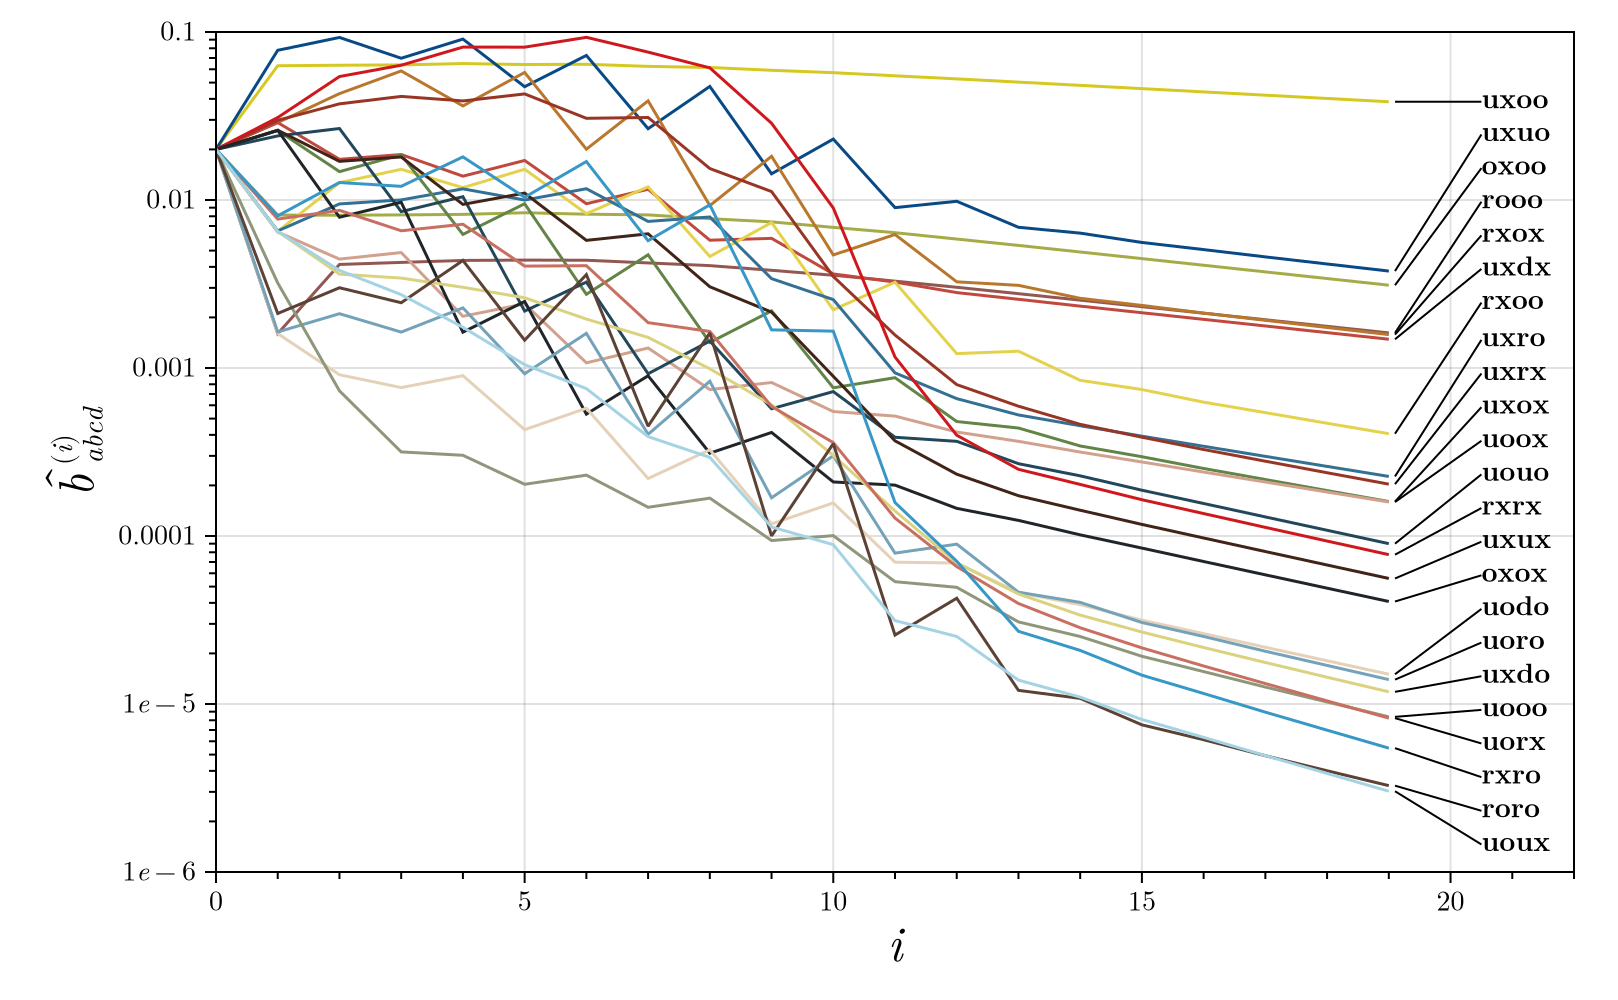

In [14]:
# plotting
using CairoMakie, ColorSchemes

function int_power_of_10_scientific_LaTeX(value)
    if value < 1e-4
        return L"1e{%$(Int(log10(value)))}"
    elseif value > 1e4
        return L"1e\,{%$(Int(log10(value)))}"
    elseif value >= 1.0
        return L"%$(Int(value))"
    else
        return L"{%$value}"
    end
end

function int_LaTeX(value)
    L"%$(Int(value))"
end

fig = Figure(; size=(500 * (1 + sqrt(5)) / 2, 500))
ax = Axis(fig[1, 1],
    yscale=log10,
    yticks=[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    ytickformat=values -> int_power_of_10_scientific_LaTeX.(values),
    yminorticksvisible=true,
    yminorticks=IntervalsBetween(9),
    xminorticksvisible=true,
    xminorticks=IntervalsBetween(5),
    xtickformat=values -> int_LaTeX.(values),
    limits=((0.0, 22), (1e-6, 0.1)),
    xlabel=L"i",
    ylabel=L"\hat{b}_{abcd}^{(i)}",
    ylabelsize=24,
    xlabelsize=24
)

plotted_lines = Set{Float64}()
for i = 2:64
    sector_data = data[i, :]
    mid_y_local = Float64(sector_data[5])
    if !(mid_y_local in plotted_lines)
        color_local = color_map[mid_y_local]
        lines!(ax, 0:length(sector_data)-1, sector_data, color=color_local)
        #lines!(ax, 0:length(sector_data)-1, sector_data, color=:black)
        #scatter!(ax, 0:length(sector_data)-1, sector_data,)
        push!(plotted_lines, mid_y_local)
    end
end


for i = 2:length(labels_reduced)
    text!(ax, (20.5, labeling_system[i, 2] * 0.85), text=labeling_system[i, 3])
    arrows!(ax, [Point(20.5, labeling_system[i, 2])], [Point(-1.4, (labeling_system[i, 1] - labeling_system[i, 2]))]; arrowhead=' ')
end

ax.aspect = (1 + sqrt(5)) / 2



save("0.02_box_convergence.pdf", fig)
fig

## Ising model

The code below proves Proposition 3.4 (a) by iterating the master map for $19$ times and checking that $\langle 2 \rangle$ is satisfied for $i_0=15$. 

Reweighting parameters:
- $w_{\mathbf{x}}=2.3$,
- $w_{\mathbf{o}}=2.0$.

The initial hat tensor is given by $\langle 39, 40 \rangle$ with $\beta=\bar{\beta}=0.12$.


In [15]:
# this defines the initial tensor as a function of beta isingA(β)
"""
Input:
- `β:ArbReal`: inverse temperature.

Output:
- `::Array{ArbReal}`: \\hat{A}^{(0)} for the Ising model <39,40>
"""
function isingA(β::T) where {T}
    A = zeros(T, 2, 2, 2, 2)

    A[o, o, o, o] = T(1)
    A[o, x, o, x] = A[x, o, x, o] = A[x, x, x, x] = (cosh(4 * β) - 1) / (cosh(4 * β) + 3)
    A[x, x, o, o] = A[o, x, x, o] = A[o, o, x, x] = A[x, o, o, x] = sinh(4 * β) / (cosh(4 * β) + 3)
    reconnect_and_rotate(A, A)[1] # this is equivalent to <40> for rotationally symmetric tensors
end;

In [16]:
# defining the initial tensor 
A = isingA(ArbReal(12 // 100))

# defining the master map parameters
wx, wo = ArbReal(23 // 10), ArbReal(2)

A_hist = [A]
traj_len = 20
for i = 2:traj_len
    push!(A_hist, 𝔐(A_hist[i-1]; wx=wx, wo=wo)[1])
end

data = hcat((A_hist .|> x -> x[:])...); # turns A_hist into convenient 64 x traj_len matrix

i0 = 15


# this computes λ for <2,3> with i0=15
# Julia arrays are numbered from 1, so we shift the index here by 1.
# We exclude the first raw of data as it corresponds to 0000 tensor element.
λ_bound, _ = findmax(upperbound.(data[2:end, i0+2] ./ data[2:end, i0+1]))

msg = λ_bound < 1 ?
      L"$$\boxed{\text{Theorem is proven: }\;\lambda \le %$λ_bound}$$" :
      L"$$\boxed{\text{Theorem is not proven: }\;\lambda \le %$λ_bound}$$"

display(msg)

L"$$\boxed{\text{Theorem is proven: }\;\lambda \le 0.94274967438673509248}$$"

The following cells plot $\langle 41 \rangle$. 

In [17]:
#this prepares data for plotting 

labels = String[]
for ind in Iterators.product((1:d for d in [4, 2, 4, 2])...)
    push!(labels, hsects[ind[1]] * vsects[ind[2]] * hsects[ind[3]] * vsects[ind[4]])
end

data = data .|> x -> (ismissing(x) || x == 0) ? missing : x;

last_values = data[:, end]
sort_order = sortperm(last_values, rev=true)
data = data[sort_order, :]
labels = labels[sort_order] .|> x -> "\\mathbf{\\mathrm{" * x * "}}";

min_distance_between_labels = 0.21

last_y = Float64.(data[:, end])

y_to_label_list = Dict(last_y[1] => [labels[1]])
for i = 2:64
    yend = last_y[i]
    if haskey(y_to_label_list, yend)
        push!(y_to_label_list[yend], labels[i])
    else
        y_to_label_list[yend] = [labels[i]]
    end
end
y_to_reduced_label = sort(Dict(
        key => latexstring(string(sort(val; rev=true)[1]))
        for (key, val) in y_to_label_list
    ) |> collect; by=x -> x[1], rev=true)


last_y_reduced = y_to_reduced_label .|> x -> x[1]
labels_reduced = y_to_reduced_label .|> x -> x[2]

label_y = copy(last_y_reduced)

for i in 2:length(label_y)
    pos_y = label_y[i]
    while log10(label_y[i-1]) - log10(pos_y) < min_distance_between_labels
        pos_y *= 0.999
    end
    label_y[i] = pos_y
end

label_y[3:end] .*= 3.7

label_y .*= 1.5


labeling_system = hcat(last_y_reduced, label_y, labels_reduced);


mid_y = sort(unique(Float64.(data[2:end, 5])), rev=true);

color_map = Dict(entry[1] => colorscheme[entry[2]] for entry in zip(mid_y[1:end], 1:length(mid_y)));

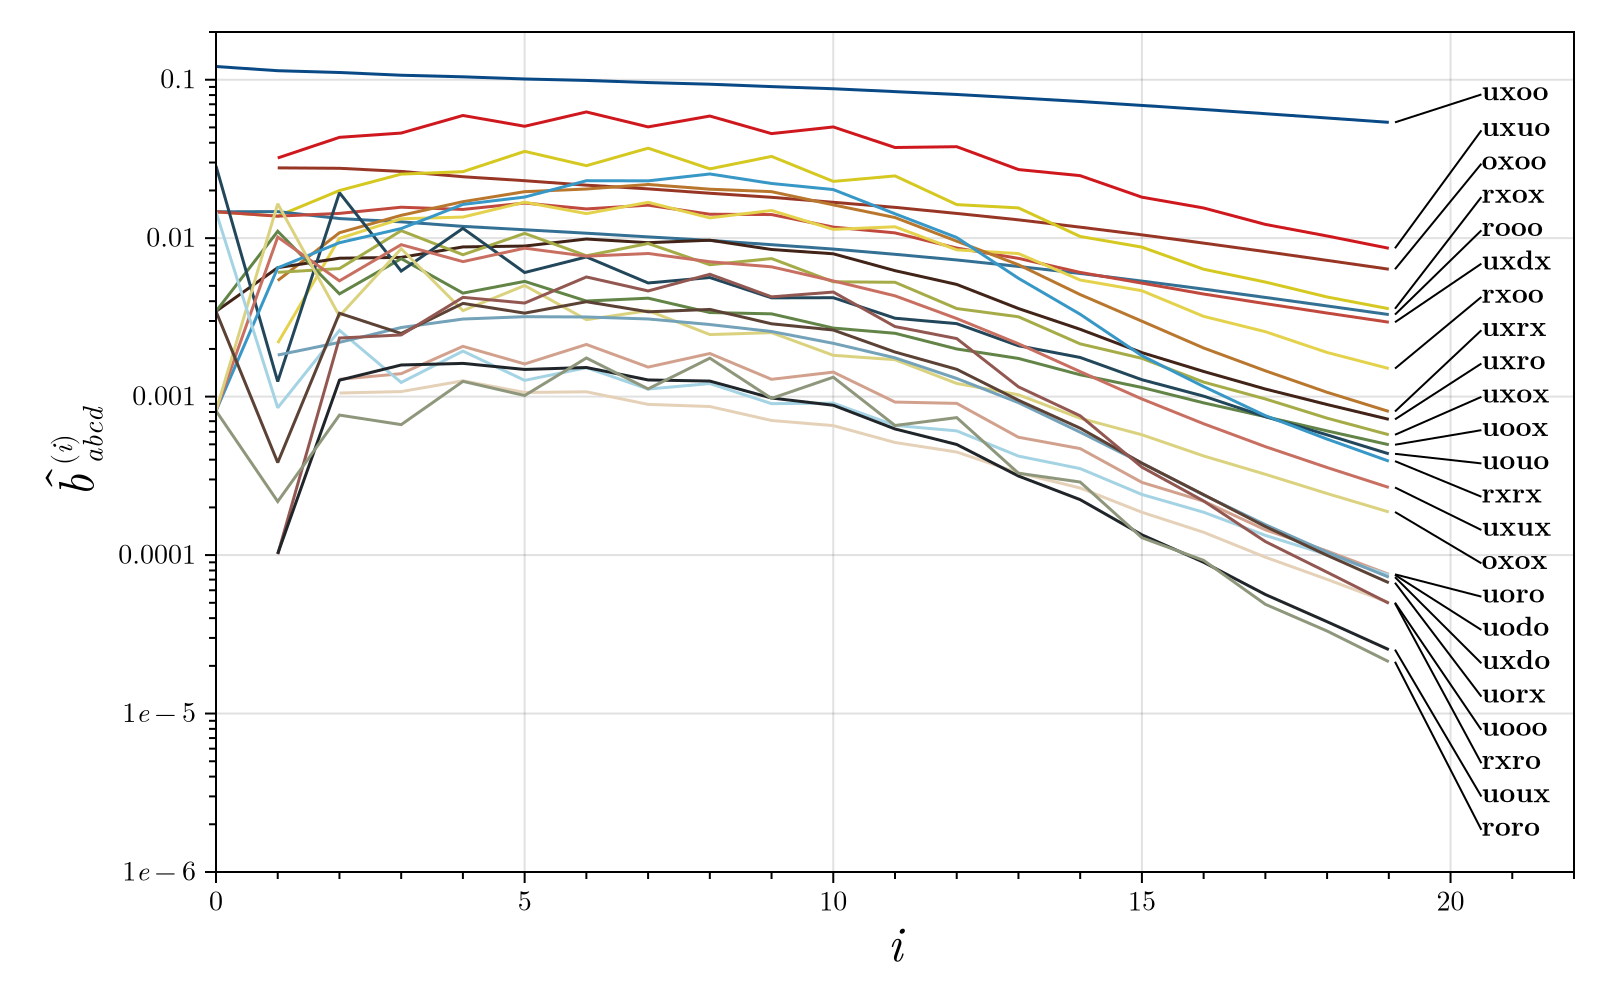

In [18]:
# plotting
fig = Figure(; size=(500 * (1 + sqrt(5)) / 2, 500))
ax = Axis(fig[1, 1],
    yscale=log10,
    yticks=[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    ytickformat=values -> int_power_of_10_scientific_LaTeX.(values),
    yminorticksvisible=true,
    yminorticks=IntervalsBetween(9),
    xminorticksvisible=true,
    xminorticks=IntervalsBetween(5),
    xtickformat=values -> int_LaTeX.(values),
    limits=((0.0, 22), (1e-6, 0.2)),
    xlabel=L"i",
    ylabel=L"\hat{b}_{abcd}^{(i)}",
    ylabelsize=24,
    xlabelsize=24
)

plotted_lines = Set{Float64}()
for i = 2:64
    sector_data = data[i, :]
    mid_y_local = Float64(sector_data[5])
    if !(mid_y_local in plotted_lines)
        color_local = color_map[mid_y_local]
        lines!(ax, 0:length(sector_data)-1, sector_data, color=color_local)
        #lines!(ax, 0:length(sector_data)-1, sector_data, color=:black)
        #scatter!(ax, 0:length(sector_data)-1, sector_data,)
        push!(plotted_lines, mid_y_local)
    end
end


for i = 2:length(labels_reduced)
    text!(ax, (20.5, labeling_system[i, 2] * 0.85), text=labeling_system[i, 3])
    arrows!(ax, [Point(20.5, labeling_system[i, 2])], [Point(-1.4, (labeling_system[i, 1] - labeling_system[i, 2]))]; arrowhead=' ')
end

ax.aspect = (1 + sqrt(5)) / 2


save("ising-convergence.pdf", fig)
fig


Below we compute free energies and plot $\langle 42 \rangle$.

In [19]:
using HCubature

"""
Input:
- `β::NumType`: the inverse temperature. Can be any numeric type (e.g., `Float64`, `BigFloat`, etc.). 
- `tol`: the relative error tolerance for the numerical integration. Defaults to `sqrt(eps(NumType))`.

Output:
- `f_exact::NumType`: the exact free energy *per spin* for the 2D Ising model at inverse temperature `β`. 
                      The return value has the same type as `β`.

Details:
- This is computed via the Onsager solution.
"""
function ising_exact_free_energy(β::NumType; tol=sqrt(eps(NumType))) where {NumType}
    k = 1 / (sinh(2 * β) * sinh(2 * β))

    ch = cosh(2 * β)
    function integrand(θ)
        return β == 0 ? log(2) : log(ch * ch + 1 / k * sqrt(1 + k^2 - 2 * k * cos(2 * θ)))
    end
    integral, _ = hquadrature(integrand, NumType(0), NumType(π); rtol=tol)
    return (log(NumType(2)) / NumType(2) + 1 / (NumType(2) * NumType(π)) * integral)
end

"""
Input:
- `β::ArbReal`: the inverse temperature.
- `wx, wo`: the reweighting parameters of 2x1 map.
- `i0`: This is i_0 from <38>. Algorithm will perform `i0+1` RG step.  

Output:
- `free_energy_upper_bound::Union{ArbReal, Missing}`: an upper bound on the Ising tensor network free energy. 
                                                      Algorithm checks if the key lemma condition <2> is satisfied at i0.
                                                      If the key lemma condition is violated, `missing` is returned.              
"""
function tensor_free_energy_ising_upper_bound(β::ArbReal; wx, wo, i0)
    if β == 0
        return ArbReal(0)
    end
    A0 = isingA(β) # A0 is A^{(0)} from <40>

    A_current = A0
    A_next = A0

    free_energy_upper_bound = ArbReal(0)
    N = ArbReal(1)
    key_lemma_condition = false

    for i = 0:i0
        A_next, N, _ = 𝔐(A_current; wx=wx, wo=wo)
        Cᵢ = log(N) # note that N is exactly \hat{\mathcal{N}}_1^2\hat{\mathcal{N}}_2 and so Cᵢ here is C_i^+ <37>. 
        free_energy_upper_bound += (ArbReal(2))^(-i - 1) * Cᵢ
        if i == i0 && all(A_next[2:end] ./ A_current[2:end] .< 1) # i==i0 is not necessary  
            key_lemma_condition = true                            # if at any step condition is satisfied 
        end                                                     # the computation is legit 
        A_current = A_next                                      # we left it here for consistency with the paper text 
    end
    free_energy_upper_bound += (ArbReal(2))^(-i0 - 1) * log(N) # this is the estimate for the tail <38>

    if key_lemma_condition
        free_energy_upper_bound
    else
        missing
    end
end

"""
Input:
- `β`: the inverse temperature.

Output:
- the contribution of the initial tensor norm (tensor `A` from <39>) to the Ising model free energy *per tensor*.
"""
free_energy_ising_tensor_norm_contribution(β) = log(cosh(4 * β) + 3);


In [20]:
using ProgressMeter
# This cell computes the free energy using the exact solution and via master function iterations.
βs = 0.0:0.001:0.12
fe_ising_exact = 2 * ising_exact_free_energy.(βs)
# this is energy per tensor, hence the factor of 2

tensor_fe_ising_exact = @. 2 * (fe_ising_exact - free_energy_ising_tensor_norm_contribution(βs))
# Here, "tensor_fe_" refers to the fact that we compute f(b^{(0)}(β)) as defined in <38>.
# The factor of 2 appears because there are twice as many b^{(0)}(β) tensors as b(β) tensors.

βs = ArbReal.(βs) # We switch to interval arithmetic to obtain rigorous upper bound.

if isfile("tensor_fe_ising_upper_bound") # delete "tensor_fe_ising_upper_bound" to repeat the computation. It may take around 30 minutes.
    tensor_fe_ising_upper_bound = deserialize("tensor_fe_ising_upper_bound")
else
    tensor_fe_ising_upper_bound = Vector{Union{eltype(βs),Missing}}(missing, length(βs))


    @showprogress for β_ind in eachindex(βs)
        β = βs[β_ind]
        tensor_fe_ising_upper_bound[β_ind] = tensor_free_energy_ising_upper_bound(β; wx=wx, wo=wo, i0=15)
    end

    if all(.!ismissing.(tensor_fe_ising_upper_bound))
        println("for every β trajectory satisfied the key lemma condition at the last step")
    else
        println("some trajectories did not satisfy the key lemma condition at the last step")
    end

    serialize("tensor_fe_ising_upper_bound", tensor_fe_ising_upper_bound)
end;

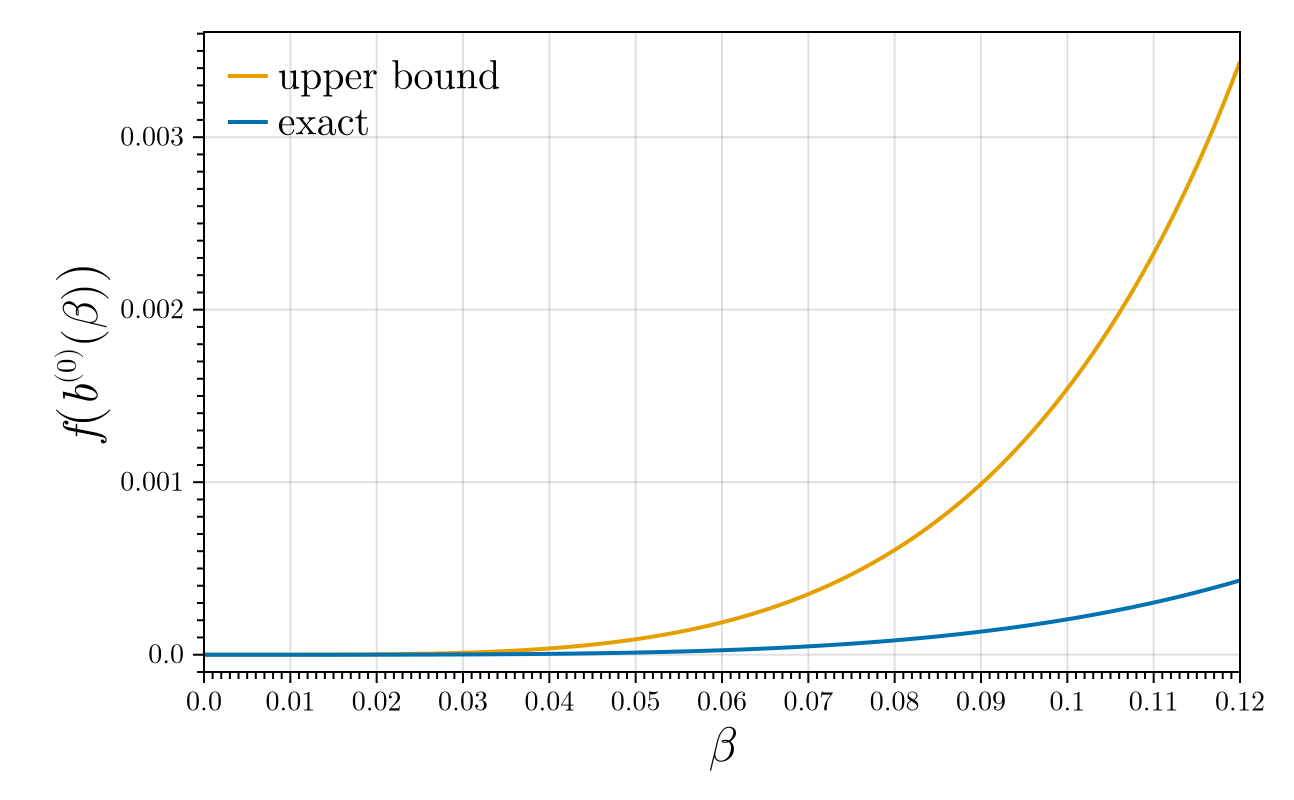

In [21]:
# this plots figure (a) in <42>
fig = Figure(size=(400 * (1 + sqrt(5)) / 2, 400))


function LaTeX_float(values; sigdigits=5)
    [L"%$(round(value;sigdigits=sigdigits))" for value in values]
end

ax1 = Axis(fig[1, 1];
    xlabel=L"\beta",
    ylabel=L"f\left(b^{(0)}(\beta)\right)",
    ylabelsize=24,
    xlabelsize=24,
    ytickformat=values -> LaTeX_float(values),
    xtickformat=values -> LaTeX_float(values),
    yminorticksvisible=true,
    yminorticks=IntervalsBetween(10),
    xminorticksvisible=true,
    xminorticks=IntervalsBetween(10),
    xticks=0.0:0.01:0.12,
    limits=((0.0, 0.12), (-0.0001, nothing)),)
lines!(ax1, βs, upperbound.(tensor_fe_ising_upper_bound); color=Makie.wong_colors()[2], label=L"\text{upper bound}", linewidth=2)
lines!(ax1, βs, tensor_fe_ising_exact; color=Makie.wong_colors()[1], label=L"\text{exact}", linewidth=2)



ax1.aspect = (1 + sqrt(5)) / 2

axislegend(ax1; position=:lt, labelsize=20, framevisible=false)

save("Ising_free_energy(a).pdf", fig)
fig


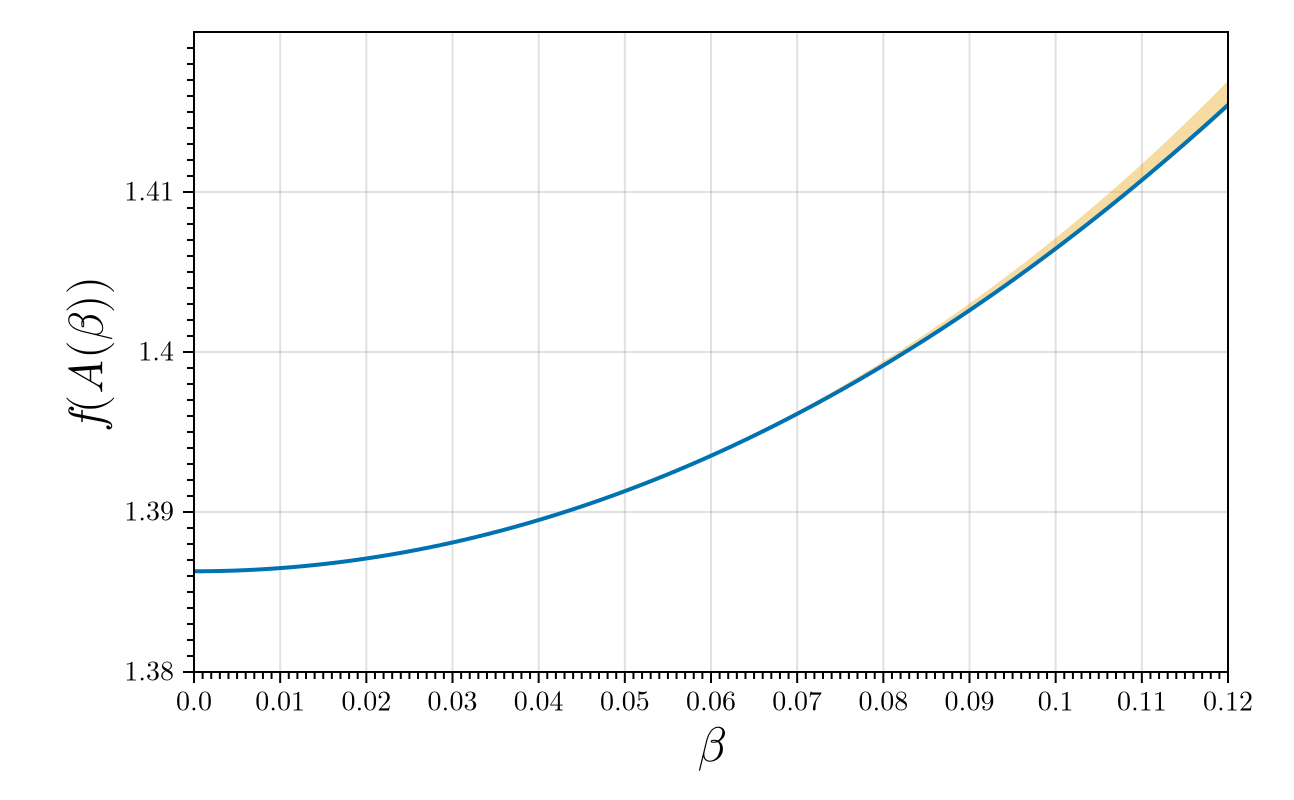

In [22]:
# this plots figure (b) in <42>
fig = Figure(size=(400 * (1 + sqrt(5)) / 2, 400))


function LaTeX_float(values; sigdigits=5)
    [L"%$(round(value;sigdigits=sigdigits))" for value in values]
end

ax1 = Axis(fig[1, 1];
    xlabel=L"\beta",
    ylabel=L"f\left(A(\beta)\right)",
    ylabelsize=24,
    xlabelsize=24,
    ytickformat=values -> LaTeX_float(values),
    xtickformat=values -> LaTeX_float(values),
    yminorticksvisible=true,
    yminorticks=IntervalsBetween(10),
    xminorticksvisible=true,
    xminorticks=IntervalsBetween(10),
    xticks=0.0:0.01:0.12,
    limits=((0.0, 0.12), (1.38, 1.42)),
)

fe_ising_low = lowerbound.(free_energy_ising_tensor_norm_contribution.(βs))
fe_ising_high = upperbound.(free_energy_ising_tensor_norm_contribution.(βs) + 1 / 2 * tensor_fe_ising_upper_bound)

band!(ax1, βs, fe_ising_low, fe_ising_high, color=Makie.wong_colors()[2], alpha=0.6)
lines!(ax1, βs, fe_ising_exact; color=Makie.wong_colors()[1], linewidth=2)


ax1.aspect = (1 + sqrt(5)) / 2

#axislegend(ax1; position=:lt, labelsize=20, framevisible=false)



save("Ising_free_energy(b).pdf", fig)
fig


## XY model

The code below proves Proposition 3.5 by iterating the master map for $19$ times and checking that $\langle 2 \rangle$ is satisfied for $i_0=15$. 

Reweighting parameters:
- $w_{\mathbf{x}}=2.3$,
- $w_{\mathbf{o}}=2.4$.

The initial hat tensor is given by $\widehat{b}^{(0)}_{\rm XY}(\beta)$ $\langle 44 \rangle$ with $\beta=\bar{\beta}=0.19$.

In [23]:
using SpecialFunctions: besseli, gamma
"""
Input:
- `n1,n2,n3,n4`: indices of A_{n_1 n_2 n_3 n_4} from <43>.
- `β:ArbReal`: inverse temperature.
- `tol`: the result of the computation is an interval with width smaller than `tol`.

Output:
- `::ArbReal`: tensor element A_{n_1 n_2 n_3 n_4} evaluated using Lemma B.1.
"""
function XY_tensor_element(n1::Int, n2::Int, n3::Int, n4::Int, β::ArbReal; tol=1e-10)
    if (n1 + n2 + n3 + n4) != 0
        return ArbReal(0)
    end
    W(k) = besseli(k, β) * besseli(k + n1, β) * besseli(k + n1 + n2, β) * besseli(k + n1 + n2 + n3, β)

    N = 2 * max(abs(n1), abs(n2), abs(n3), abs(n4)) # for simplicity we choose |k₊|=|k₋|=N

    lhs = sum(W(k) for k = -N:N) # this is the l.h.s. of <45>
    β_factor = (β / 2)^4 / (1 - (β / 2)^4)
    gap = β_factor * (W(N) + W(-N)) # this is the second term in the rhs of <45>

    while upperbound(gap) > tol
        N = N + 1
        lhs += W(N) + W(-N)
        gap = β_factor * (W(N) + W(-N))
    end

    return setinterval(lowerbound(lhs), upperbound(lhs) + upperbound(gap))
end

"""
Input:
- `N`: integer N from Lemma B.4.
- `β:ArbReal`: inverse temperature.

Output:
- `::ArbReal`: r.h.s. of <46>.
"""
function XY_square_tail_bound(N, β::ArbReal)
    TN = 2 * N^2 + 3 * N + 1
    KN = 2 * TN * (4N + 1)^2 / (gamma(ArbReal(N) / 2 + 1))^4
    return 4 * KN * (besseli(0, β)^4 / (1 - (β / 2)^4))^2 * (β / 2)^(2 * N) / (1 - (β / 2)^2)
end

"""
Input:
- `β:ArbReal`: inverse temperature.
- `tol`: the output will ne an array of intervals with width of order `tol`.

Output:
- `::Array{ArbReal}`: \\hat{A}^{(0)} for the XY model <44>
"""
function XYA(β::ArbReal; tol=1e-10, N=10)
    T = typeof(β)
    A = zeros(T, 2, 2, 2, 2)

    nrm = XY_tensor_element(0, 0, 0, 0, β; tol=tol)
    oooo = T(1)

    tail_square_bound = XY_square_tail_bound(N, β)
    while tail_square_bound >= tol^2
        N += 1
        tail_square_bound = XY_square_tail_bound(N, β)
    end

    num_space_indices = vcat(-collect(1:(N-1)), collect(1:(N-1)))

    # for very small betta the lower bound of (XY_tensor_element(n, -n, 0, 0, β; tol=tol))^2
    # may be negative (this is how ArbNumerics works unfortunately)
    # to avoid issues with this, we take the upper bound here. Note that this 
    # still gives a valid hat tensor.   
    xxoo_square = sum(upperbound((XY_tensor_element(n, -n, 0, 0, β; tol=tol))^2) 
                      for n ∈ num_space_indices)                                                                                                            
                                                                             
    xxoo = sqrt(setinterval(lowerbound(xxoo_square), upperbound(xxoo_square) + upperbound(tail_square_bound))) / nrm
    # we don't really care here what to put as the lower bound of numerator as after all we only need the hat tensor. 

    xoxo_square = sum(upperbound((XY_tensor_element(n, 0, -n, 0, β; tol=tol))^2)
                      for n ∈ num_space_indices)
    xoxo = sqrt(setinterval(lowerbound(xoxo_square), upperbound(xoxo_square) + upperbound(tail_square_bound))) / nrm

    xxxo_square = sum(upperbound((XY_tensor_element(n1, n2, -n1 - n2, 0, β; tol=tol))^2)
                      for n1 ∈ num_space_indices, n2 ∈ num_space_indices
                      if (-n1 - n2) ∈ num_space_indices)
    xxxo = sqrt(setinterval(lowerbound(xxxo_square), upperbound(xxxo_square) + upperbound(tail_square_bound))) / nrm

    xxxx_square = sum(upperbound((XY_tensor_element(n1, n2, n3, -n1 - n2 - n3, β; tol=tol))^2)
                      for n1 ∈ num_space_indices, n2 ∈ num_space_indices, n3 ∈ num_space_indices
                      if (n1 + n2 + n3) ∈ num_space_indices)
    xxxx = sqrt(setinterval(lowerbound(xxxx_square), upperbound(xxxx_square) + upperbound(tail_square_bound))) / nrm




    A[o, o, o, o] = oooo # this is exactly 1 so we don't need and upperbound
    A[x, x, o, o] = A[o, x, x, o] = A[o, o, x, x] = A[x, o, o, x] = upperbound(xxoo) # strictly speaking we don't need an upper bound here as well, but 
    A[x, o, x, o] = A[o, x, o, x] = upperbound(xoxo)                                 # this will only make errors in the computation smaller 
    A[x, x, x, o] = A[o, x, x, x] = A[x, o, x, x] = A[x, x, o, x] = upperbound(xxxo) # while keeping the tensor a valid hat tensor
    A[x, x, x, x] = upperbound(xxxx)                                                

    reconnect_and_rotate(A, A)[1]
end;

In [24]:
# defining the initial tensor 
A = XYA(ArbReal(19 // 100))

# defining the master map parameters
wx, wo = ArbReal(23 // 10), ArbReal(24 // 10)


A_hist = [A]
traj_len = 20
for i = 2:traj_len
    push!(A_hist, 𝔐(A_hist[i-1]; wx=wx, wo=wo)[1])
end

data = hcat((A_hist .|> x -> x[:])...); # turns A_hist into convenient 64 x traj_len matrix

i0 = 15

# this computes λ for <2,3> with i0=15
# Julia arrays are numbered from 1, so we shift the index here by 1.
# We exclude the first raw of data as it corresponds to 0000 tensor element.
λ_bound, _ = findmax(upperbound.(data[2:end, i0+2] ./ data[2:end, i0+1]))

msg = λ_bound < 1 ?
      L"$$\boxed{\text{Theorem is proven: }\;\lambda \le %$λ_bound}$$" :
      L"$$\boxed{\text{Theorem is not proven: }\;\lambda \le %$λ_bound}$$"

display(msg)

L"$$\boxed{\text{Theorem is proven: }\;\lambda \le 0.85176549896785543655}$$"

In [25]:
#this prepares data for plotting 


labels = String[]
for ind in Iterators.product((1:d for d in [4, 2, 4, 2])...)
    push!(labels, hsects[ind[1]] * vsects[ind[2]] * hsects[ind[3]] * vsects[ind[4]])
end

data = data .|> x -> (ismissing(x) || x == 0) ? missing : x;

last_values = data[:, end]
sort_order = sortperm(last_values, rev=true)
data = data[sort_order, :]
labels = labels[sort_order] .|> x -> "\\mathbf{\\mathrm{" * x * "}}";

min_distance_between_labels = 0.32

last_y = Float64.(data[:, end])

y_to_label_list = Dict(last_y[1] => [labels[1]])
for i = 2:64
    yend = last_y[i]
    if haskey(y_to_label_list, yend)
        push!(y_to_label_list[yend], labels[i])
    else
        y_to_label_list[yend] = [labels[i]]
    end
end
y_to_reduced_label = sort(Dict(
        key => latexstring(string(sort(val; rev=true)[1]))
        for (key, val) in y_to_label_list
    ) |> collect; by=x -> x[1], rev=true)


last_y_reduced = y_to_reduced_label .|> x -> x[1]
labels_reduced = y_to_reduced_label .|> x -> x[2]

label_y = copy(last_y_reduced)

for i in 2:length(label_y)
    pos_y = label_y[i]
    while log10(label_y[i-1]) - log10(pos_y) < min_distance_between_labels
        pos_y *= 0.999
    end
    label_y[i] = pos_y
end


label_y[3:end] .*= 14

label_y .*= 2


labeling_system = hcat(last_y_reduced, label_y, labels_reduced);


mid_y = sort(unique(Float64.(data[2:end, 5])), rev=true);

color_map = Dict(entry[1] => colorscheme[entry[2]] for entry in zip(mid_y[1:end], 1:length(mid_y)));

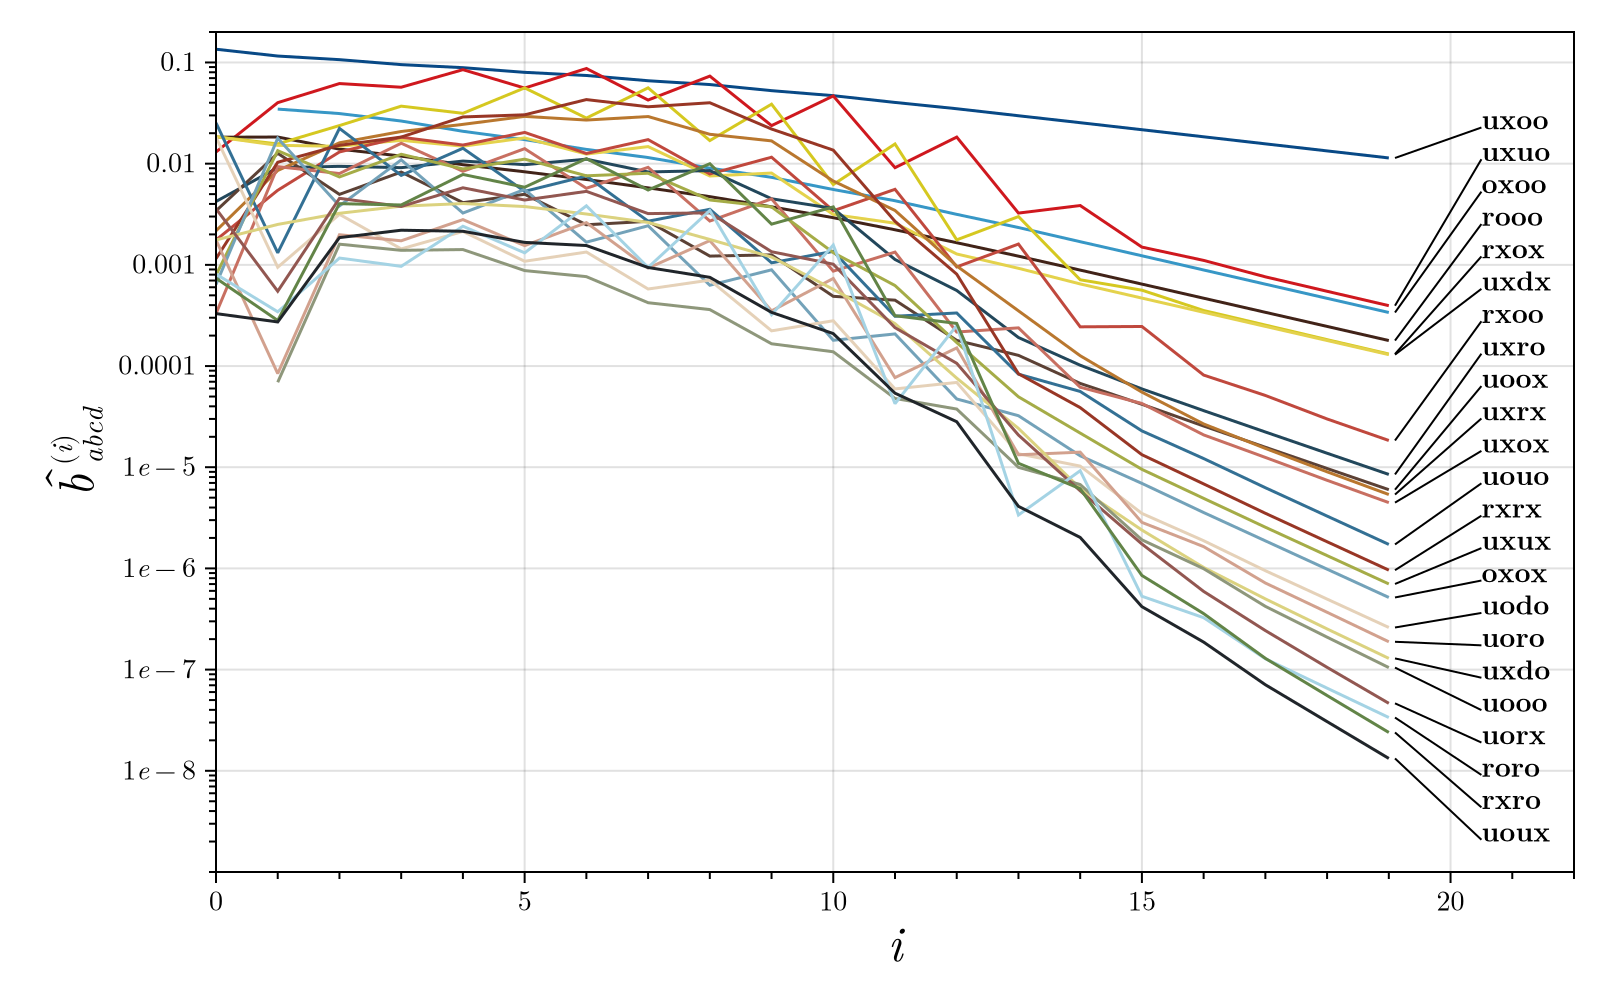

In [26]:
# plotting
fig = Figure(; size=(500 * (1 + sqrt(5)) / 2, 500))
ax = Axis(fig[1, 1],
    yscale=log10,
    yticks=[1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    ytickformat=values -> int_power_of_10_scientific_LaTeX.(values),
    yminorticksvisible=true,
    yminorticks=IntervalsBetween(9),
    xminorticksvisible=true,
    xminorticks=IntervalsBetween(5),
    xtickformat=values -> int_LaTeX.(values),
    limits=((0.0, 22), (1e-9, 0.2)),
    xlabel=L"i",
    ylabel=L"\hat{b}_{abcd}^{(i)}",
    ylabelsize=24,
    xlabelsize=24
)

plotted_lines = Set{Float64}()
for i = 2:64
    sector_data = data[i, :]
    mid_y_local = Float64(sector_data[5])
    if !(mid_y_local in plotted_lines)
        color_local = color_map[mid_y_local]
        lines!(ax, 0:length(sector_data)-1, sector_data, color=color_local)
        #lines!(ax, 0:length(sector_data)-1, sector_data, color=:black)
        #scatter!(ax, 0:length(sector_data)-1, sector_data,)
        push!(plotted_lines, mid_y_local)
    end
end


for i = 2:length(labels_reduced)
    text!(ax, (20.5, labeling_system[i, 2] * 0.85), text=labeling_system[i, 3])
    arrows!(ax, [Point(20.5, labeling_system[i, 2])], [Point(-1.4, (labeling_system[i, 1] - labeling_system[i, 2]))]; arrowhead=' ')
end

ax.aspect = (1 + sqrt(5)) / 2


save("XY-convergence.pdf", fig)
fig


In order to conclude that for all $\beta \leq 0.19$ the system is in the high-temperature (HT) phase, we should either prove that $\widehat{b}^{(0)}_{\rm XY}(\beta)$ is elementwise monotonic, or show in any other way that for $\beta \leq 0.19$, 
\begin{equation}
\widehat{b}^{(0)}_{\rm XY}(\beta) \leq \widehat{b}^{(0)}_{\rm XY}(0.19) \quad \text{elementwise.} \tag{*}
\end{equation}
We do believe that $\widehat{b}^{(0)}_{\rm XY}(\beta)$ is elementwise monotonic with respect to $\beta$, at least in the region of interest, but proving this requires some extra work. Instead, we will prove (\*). Even this, however, is slightly difficult, so we will weaken the result a bit. Instead of proving (\*) for all $\beta \leq 0.19$, we will prove it for $\beta \leq 0.19 - \delta$, where $\delta$ is a small number. Thus, we aim to prove that for all $\beta \leq 0.19 - \delta$, the XY model is in the HT phase.

The code below evaluates $\widehat{b}^{(0)}_{\rm XY}(\beta)$ on overlapping intervals $e_1, e_2, \ldots, e_n$ of width $\sim \delta$ using interval arithmetic. For each interval $e_k$, the code returns the tensor $\widehat{b}^{(0)}_{\rm XY}(e_k)$, whose elements are themselves intervals enclosing all possible values of the corresponding elements of $\hat{b}^{(0)}_{\rm XY}(\beta)$ for $\beta \in e_k$. We then check that $\widehat{b}^{(0)}_{\rm XY}(e_k) \leq \widehat{b}^{(0)}_{\rm XY}(0.19)$ elementwise.

We will ensure that the intervals $e_k$ cover $[0, 0.19]$ and that the inequality $\widehat{b}^{(0)}_{\rm XY}(e_k) \leq \widehat{b}^{(0)}_{\rm XY}(0.19)$ is satisfied for all but the first interval $e_1$. Therefore, (\*) is satisfied for all $\beta \in [0, 0.19] \setminus e_1 = [0, 0.19 - \delta]$. Consequently, for all values $\beta \leq 0.19 - \delta$, the system is in the HT phase.


In [27]:
β_bar = ArbReal(19 // 100)

δ = 5e-5
ϵ = 1e-20
N = ceil(Int,0.19/δ)

e = [setinterval(lowerbound(β_bar)-δ, upperbound(β_bar))]
for i in 2:N
    β_new = setinterval(lowerbound(e[i - 1]) - δ, lowerbound(e[i - 1]) + ϵ)
    push!(e, β_new)
end

holes = false # we need to check that intervals fully cover [0,0.19]
for i in 2:N
    if !(upperbound(e[i]) > lowerbound(e[i - 1]))
        holes = true
        break
    end
end
if holes
    throw("holes in intervals are detected")
end

In [ ]:
tmp=XYA(e[1]; tol=δ/10, N=3)
ek_tensors=[ copy(tmp)  for _=1:length(e)]
progress_bar=Progress(length(e))
Threads.@threads for k in eachindex(e)
    ek_tensors[k]=XYA(e[k]; tol=δ/10, N=3)
    next!(progress_bar)
end
finish!(progress_bar)
# This may potentially crush silently
# if progress stalls, try again without multithreading.
# For this simply remove "Threads.@threads" 

Progress: 100%|█████████████████████████████████████████| Time: 0:04:58


In [29]:
A = XYA(ArbReal(19 // 100));
check_inequality(ek_tensor)=((ek_tensor |> x->x.<A) .|| (ek_tensor |> x->x.==A)) |> all 
test_results=check_inequality.(ek_tensors)
only_e1_failed=findall(x->x==0,test_results)==[1]

if only_e1_failed
    msg=L"$$\boxed{\text{Inequality (*) is satisfied for all intervals except } e_1 \Rightarrow \text{ all } \beta \leq %$(upperbound(e[2])) \text{ belong to the HT phase} }$$" 
end    


L"$$\boxed{\text{Inequality (*) is satisfied for all intervals except } e_1 \Rightarrow \text{ all } \beta \leq 0.18995000000002842168 \text{ belong to the HT phase} }$$"